## 머신러닝
데이터: 학생 성적에 관한 소규모 데이터

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
import seaborn as sns
from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
import numpy as np
from xgboost import plot_importance

In [2]:
data_dir = '/hdd/data/adp_data/'

df = pd.read_csv(data_dir + 'student_data.csv', encoding = 'cp949')
df.head()

,school,sex,paid,activities,famrel,freetime,goout,Dalc,Walc,health,absences,grade,G1,G2
0,GP,F,no,no,4.0,3.0,4.0,1.0,1.0,3.0,6.0,6,5,6
1,GP,F,no,no,5.0,3.0,3.0,1.0,1.0,3.0,4.0,5,5,5
2,GP,F,yes,no,4.0,3.0,2.0,2.0,3.0,3.0,10.0,8,7,8
3,GP,F,yes,yes,3.0,2.0,2.0,1.0,1.0,5.0,2.0,15,15,14
4,GP,F,yes,no,4.0,3.0,2.0,1.0,2.0,5.0,4.0,9,6,10


(1) 시각화를 포함 탐색적 자료분석을 시행하시오(EDA).

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   school      395 non-null    object 
 1   sex         395 non-null    object 
 2   paid        395 non-null    object 
 3   activities  395 non-null    object 
 4   famrel      394 non-null    float64
 5   freetime    393 non-null    float64
 6   goout       392 non-null    float64
 7   Dalc        391 non-null    float64
 8   Walc        393 non-null    float64
 9   health      391 non-null    float64
 10  absences    392 non-null    float64
 11  grade       395 non-null    int64  
 12  G1          395 non-null    int64  
 13  G2          395 non-null    int64  
dtypes: float64(7), int64(3), object(4)
memory usage: 43.3+ KB


famrel, freetime, goout, Dalc, Walc, health, absences 변수에서 결측치가 발견됨. 확인 필요

In [4]:
print(df.nunique())

school         2
sex            2
paid           2
activities     2
famrel         5
freetime       5
goout          5
Dalc           5
Walc           5
health         5
absences      34
grade         19
G1            17
G2            17
dtype: int64


In [5]:
print(df.describe())

           famrel    freetime       goout        Dalc        Walc      health  \
count  394.000000  393.000000  392.000000  391.000000  393.000000  391.000000   
mean     3.944162    3.239186    3.114796    1.470588    2.284987    3.562660   
std      0.897794    0.994265    1.112397    0.873266    1.287778    1.386949   
min      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
25%      4.000000    3.000000    2.000000    1.000000    1.000000    3.000000   
50%      4.000000    3.000000    3.000000    1.000000    2.000000    4.000000   
75%      5.000000    4.000000    4.000000    2.000000    3.000000    5.000000   
max      5.000000    5.000000    5.000000    5.000000    5.000000    5.000000   

         absences       grade          G1          G2  
count  392.000000  395.000000  395.000000  395.000000  
mean     5.676020   10.660759   10.908861   10.713924  
std      8.013393    3.719390    3.319195    3.761505  
min      0.000000    1.000000    3.000000    0

In [6]:
categories = ['school', 'sex', 'paid', 'activities']
for category in categories:
    print('--------{}--------'.format(category))
    print(df[category].value_counts())
    print('')
    print('')

--------school--------
school
GP    349
MS     46
Name: count, dtype: int64


--------sex--------
sex
F    208
M    187
Name: count, dtype: int64


--------paid--------
paid
no     214
yes    181
Name: count, dtype: int64


--------activities--------
activities
yes    201
no     194
Name: count, dtype: int64




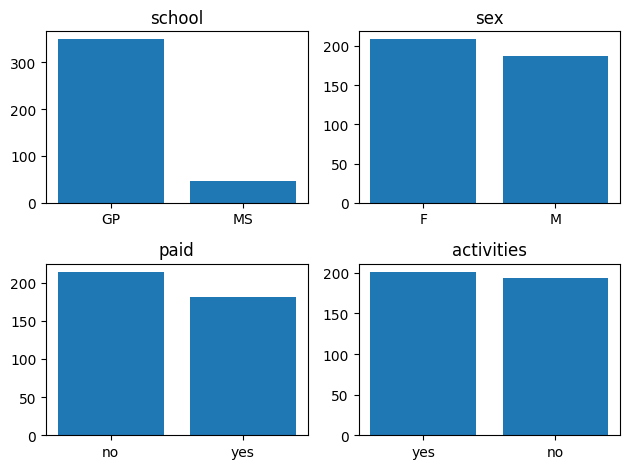

In [7]:
fig, axs = plt.subplots(2, 2)
for i, category in enumerate(categories):
    axs.flat[i].bar(
        df[category].value_counts().index,
        df[category].value_counts().values
    )
    axs.flat[i].set_title(category)
plt.tight_layout() # 그래프 간격 자동 조정
plt.show()

object 타입은 더미 변수로 변환할 필요가 있음. school 변수를 제외하고는 비율에 큰 차이가 없음.

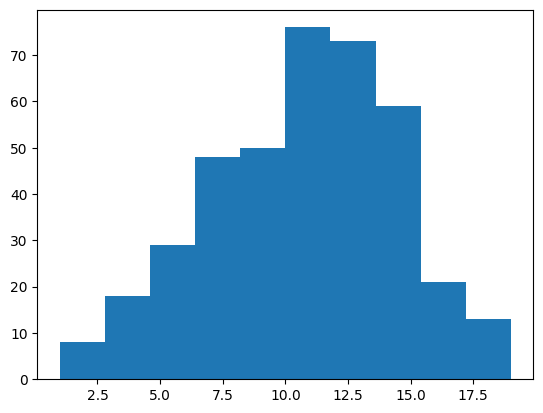

In [8]:
plt.hist(df['grade'])
plt.show()

In [9]:
stats.shapiro(df['grade'])

ShapiroResult(statistic=np.float64(0.987124064270881), pvalue=np.float64(0.0014292315891789487))

grade 변수는 정규분포를 따른다고 할 수 있음. 회귀를 사용할 수 있음.

<Axes: >

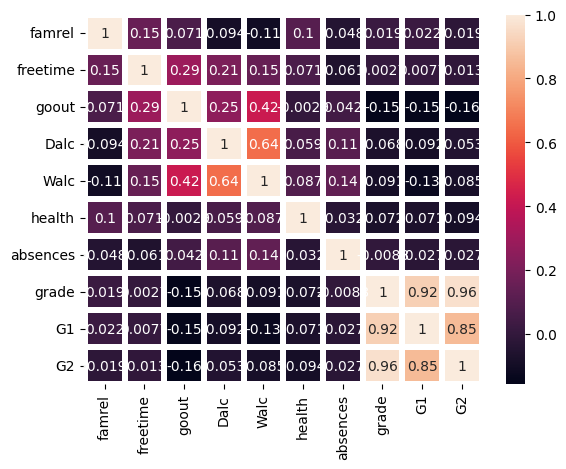

In [10]:
df_cor = df.drop(columns = categories).corr(method = 'pearson')
sns.heatmap(
    df_cor,
    xticklabels = df_cor.columns,
    yticklabels = df_cor.columns,
    annot = True,
    linewidths = 3
)

grade를 제외한 설명변수들 간의 상관관계는 크지 않음. G1과 G2 변수는 어떤 변수인지 확인이 필요함.

(2) 결측치를 식별, 예측하는 두 가지 방법을 쓰고, 이를 선택한 이유를 설명하시오.

In [11]:
df[df.isna().any(axis = 1)]

,school,sex,paid,activities,famrel,freetime,goout,Dalc,Walc,health,absences,grade,G1,G2
9,GP,M,yes,yes,5.0,5.0,NaN,1.0,1.0,5.0,0.0,15,14,15
14,GP,M,no,no,NaN,5.0,2.0,1.0,1.0,3.0,0.0,15,14,16
15,GP,F,no,no,4.0,4.0,4.0,1.0,2.0,2.0,NaN,14,14,14
25,GP,F,yes,no,1.0,2.0,2.0,1.0,NaN,5.0,14.0,8,6,9
39,GP,F,yes,yes,4.0,3.0,1.0,1.0,1.0,NaN,8.0,13,14,13
40,GP,F,no,yes,3.0,3.0,NaN,1.0,2.0,3.0,25.0,9,7,10
49,GP,F,no,yes,4.0,4.0,4.0,1.0,1.0,NaN,2.0,7,7,7
61,GP,F,no,yes,5.0,5.0,5.0,NaN,5.0,5.0,6.0,10,10,8
71,GP,M,no,no,3.0,3.0,3.0,NaN,1.0,3.0,0.0,10,10,10
82,GP,F,yes,no,4.0,4.0,4.0,1.0,1.0,5.0,NaN,6,7,6


단순대치법, knn대치법을 사용할 수 있음. 결측치가 모두 수치형이므로 knn 대치법을 사용.

In [12]:
imputer = KNNImputer()
df_filled = imputer.fit_transform(df.drop(columns = categories))
df_filled = pd.DataFrame(df_filled, columns = df.columns.difference(categories))
df[df.columns.difference(categories)] = df_filled

df.isna().sum()

school        0
sex           0
paid          0
activities    0
famrel        0
freetime      0
goout         0
Dalc          0
Walc          0
health        0
absences      0
grade         0
G1            0
G2            0
dtype: int64

(3) 범주형 변수 인코딩이 필요한 경우를 식별하고, 변환을 적용하시오. 이를 선택한 이유를 설명하시오.

In [13]:
df = pd.get_dummies(data = df, columns = categories, drop_first = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   famrel          395 non-null    float64
 1   freetime        395 non-null    float64
 2   goout           395 non-null    float64
 3   Dalc            395 non-null    float64
 4   Walc            395 non-null    float64
 5   health          395 non-null    float64
 6   absences        395 non-null    float64
 7   grade           395 non-null    float64
 8   G1              395 non-null    float64
 9   G2              395 non-null    float64
 10  school_MS       395 non-null    bool   
 11  sex_M           395 non-null    bool   
 12  paid_yes        395 non-null    bool   
 13  activities_yes  395 non-null    bool   
dtypes: bool(4), float64(10)
memory usage: 32.5 KB


(4) 데이터 분할 방법을 2가지 쓰고 적절한 데이터 분할을 적용하시오. 이를 선택한 이유를 설명하시오.

In [14]:
X = df.drop('grade', axis = 1)
y = df['grade']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 526)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(276, 13) (119, 13)
(276,) (119,)


홀드아웃방법, 층화추출기법이 있음. 종속변수가 연속형이므로 홀드아웃 사용.

(5) svm, xgboost, randomforest 3개의 알고리즘 공통점을 쓰고 학생성적 예측 분석에 적합한 알고리즘인지 설명하시오.

세 알고리즘은 모두 회귀, 분류 문제를 모두 풀 수 있다. 모두 사용가능한 알고리즘.

(6) 세 가지 모델 모두 모델링해보고 가장 적합한 알고리즘을 선택하시오. 이를 선택한 이유와 모델의 한계점, 보완 가능한 부분을 설명하고, 현업에서 주의할 점 등에 대해 기술하시오.

### SVM

In [15]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns = X_train.columns
)
X_test_scaled = pd.DataFrame(
    scaler.transform(X_test),
    columns = X_test.columns
)

In [16]:
param_grid = [
    {'C': [0.1, 1, 10, 100], 'gamma': [0.001, 0.01, 0.1, 1, 10]}
]
grid_svm = GridSearchCV(SVR(), param_grid = param_grid, cv = 5)
grid_svm.fit(X_train_scaled, y_train)
result = pd.DataFrame(grid_svm.cv_results_['params'])
result['mean_test_score'] = grid_svm.cv_results_['mean_test_score']
result.sort_values(by = 'mean_test_score', ascending = False)

,C,gamma,mean_test_score
11,10.0,0.010,0.838468
15,100.0,0.001,0.821132
16,100.0,0.010,0.814650
10,10.0,0.001,0.782095
6,1.0,0.010,0.773636
12,10.0,0.100,0.755089
17,100.0,0.100,0.743187
7,1.0,0.100,0.699955
5,1.0,0.001,0.280511
2,0.1,0.100,0.253660


In [17]:
svr = SVR(C = 10, gamma = 0.01)
svr.fit(X_train_scaled, y_train)

print('R2: ', svr.score(X_test_scaled, y_test))
print(
    'RMSE: ',
    np.sqrt(mean_squared_error(y_test, svr.predict(X_test_scaled)))
)

R2:  0.837732250415039
RMSE:  1.320823974627929


### RandomForest

In [18]:
rf_grid = [{
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_split': [2, 4, 6, 8, 10]
}]
rf = GridSearchCV(
    RandomForestRegressor(n_estimators = 100),
    param_grid = rf_grid,
    cv = 5
)
rf.fit(X_train, y_train)

print(rf.best_params_)
print('R2: ', rf.score(X_test, y_test))
print(
    'RMSE: ',
    np.sqrt(mean_squared_error(y_test, rf.predict(X_test)))
)

{'max_depth': 8, 'min_samples_split': 8}
R2:  0.8811011282235373
RMSE:  1.1306227073575024


### xgboost

In [19]:
xgb_grid = [{
    'max_depth': [2, 4, 6, 8, 10]
}]
xgb = GridSearchCV(
    XGBRegressor(n_estimators = 1000),
    param_grid = xgb_grid,
    cv = 5
)
xgb.fit(X_train, y_train)
xgb.score(X_test, y_test)

print(xgb.best_params_)
print('R2: ', xgb.score(X_test, y_test))
print(
    'RMSE: ',
    np.sqrt(mean_squared_error(y_test, xgb.predict(X_test)))
)

{'max_depth': 6}
R2:  0.873388970022006
RMSE:  1.1667145329957105


<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

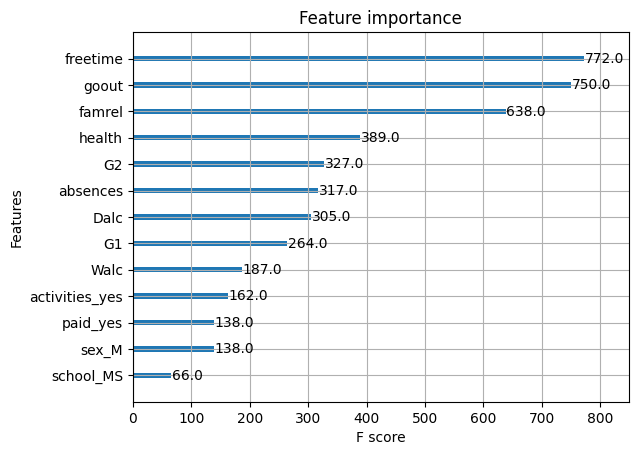

In [20]:
plot_importance(xgb.best_estimator_)